In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px
from sklearn.impute import SimpleImputer, KNNImputer
from tqdm import tqdm_notebook
from venn import venn
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import MinMaxScaler

In [379]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
seed = 42

# compute less correlated proteins

In [6]:
meta = pd.read_csv("../../data/E0022_P06_final_sample_map_no_control.txt", sep='\t')
protein_RUV = pd.read_csv("../../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt", sep='\t')

In [7]:
ccle_protein_common = pd.read_csv("../../data/ccle/protein_matrix_common_ruv.tsv", sep='\t')

In [8]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [9]:
rna_raw = pd.read_csv("../../data/rna/rnaseq_voom.csv", index_col=0).T

rna_raw.index.name='SIDM'

rna_raw = rna_raw.reset_index()

In [10]:
rna_sample = pd.merge(rna_raw,
                      meta[['SIDM',
                            'Cell_line']].drop_duplicates()).drop(['SIDM'],
                                                                  axis=1)
# rna_sample = rna_sample.set_index(['Cell_line'])

In [11]:
corr_dict_sanger = {'protein': [], 'corr': []}
gene_not_found = []
protein_not_found = []
for protein in protein_RUV.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(protein_RUV[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict_sanger['protein'].append(protein)
        corr_dict_sanger['corr'].append(spearmanr(data.iloc[:, 1], data.iloc[:, 2])[0])
corr_dict_sanger = pd.DataFrame(corr_dict_sanger)

In [12]:
corr_dict_ccle = {'protein': [], 'corr': []}
gene_not_found = []
protein_not_found = []
for protein in ccle_protein_common.drop(['Cell_line'], axis=1).columns:
    if protein not in name_map_dict:
        protein_not_found.append(protein)
        continue
    gene = name_map_dict[protein]
    if gene in rna_sample.columns:
        data = pd.merge(ccle_protein_common[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict_ccle['protein'].append(protein)
        corr_dict_ccle['corr'].append(spearmanr(data.iloc[:, 1], data.iloc[:, 2])[0])
corr_dict_ccle = pd.DataFrame(corr_dict_ccle)

In [13]:
corr_dict_merged = pd.merge(corr_dict_sanger, corr_dict_ccle, on=['protein'], suffixes=['_sanger', '_ccle'])

In [14]:
corr_dict_merged.head()

,protein,corr_sanger,corr_ccle
0,1433B_HUMAN,0.201402,0.450341
1,1433E_HUMAN,0.213233,0.438729
2,1433F_HUMAN,0.327231,0.518768
3,1433G_HUMAN,0.459458,0.494936
4,1433S_HUMAN,0.489773,0.816371


In [15]:
corr_dict_merged['corr_avg'] = corr_dict_merged.apply(
    lambda row: np.average([row['corr_sanger'], row['corr_ccle']]), axis=1)
corr_dict_merged['corr_diff'] = corr_dict_merged.apply(
    lambda row: row['corr_sanger'] - row['corr_ccle'], axis=1)

In [16]:
corr_dict_merged = corr_dict_merged[['protein', 'corr_sanger', 'corr_ccle', 'corr_diff', 'corr_avg']]

In [17]:
corr_dict_merged

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
0,1433B_HUMAN,0.201402,0.450341,-0.248939,0.325871
1,1433E_HUMAN,0.213233,0.438729,-0.225496,0.325981
2,1433F_HUMAN,0.327231,0.518768,-0.191538,0.423000
3,1433G_HUMAN,0.459458,0.494936,-0.035478,0.477197
4,1433S_HUMAN,0.489773,0.816371,-0.326598,0.653072
...,...,...,...,...,...
3161,ZO2_HUMAN,0.656357,0.876658,-0.220301,0.766507
3162,ZPR1_HUMAN,0.438820,0.530438,-0.091619,0.484629
3163,ZRAB2_HUMAN,0.396410,0.354159,0.042252,0.375285
3164,ZW10_HUMAN,0.222987,0.322718,-0.099731,0.272852


In [18]:
corr_dict_merged[corr_dict_merged['corr_diff'].abs() < 0.05].sort_values(by=['corr_avg']).head(100)

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
1752,NU205_HUMAN,-0.027487,-0.032571,0.005084,-0.030029
2360,RM39_HUMAN,-0.014903,0.018709,-0.033612,0.001903
2394,RPB3_HUMAN,0.039071,-0.010034,0.049105,0.014518
2353,RM18_HUMAN,-0.003322,0.037441,-0.040763,0.017060
2006,POMP_HUMAN,0.051871,0.008838,0.043033,0.030355
...,...,...,...,...,...
814,ELYS_HUMAN,0.167700,0.192226,-0.024526,0.179963
811,ELOB_HUMAN,0.189261,0.173245,0.016016,0.181253
1480,MATR3_HUMAN,0.162645,0.200039,-0.037394,0.181342
1226,IF4A3_HUMAN,0.198456,0.168580,0.029876,0.183518


In [19]:
corr_dict_merged.sort_values(
    by=['corr_avg']).to_csv("../../data/protein_rna_correlations.csv",
                            index=False)

In [20]:
corr_dict_merged[corr_dict_merged['protein']=='LMNA_HUMAN']

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
1411,LMNA_HUMAN,0.868709,0.67253,0.19618,0.77062


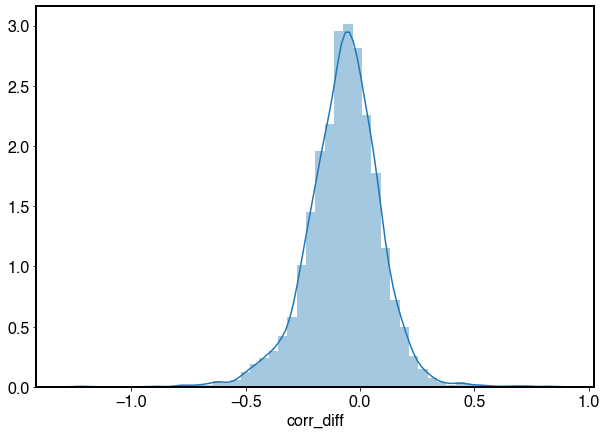

In [21]:
sns.distplot(corr_dict_merged['corr_diff'])

# tissue type features

In [784]:
proteins = np.array([x for x in protein_RUV.columns if '_HUMAN' in x])

In [785]:
lgbm_shap_values = pickle.load(open("../../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "rb"))

topN = 20
shap_tissue_set = []
for tissue_shap in lgbm_shap_values:
    shap_top_proteins = proteins[np.argsort(-np.mean(np.abs(tissue_shap),axis=0))][:topN]
    shap_tissue_set.extend([f"{x}" for x in shap_top_proteins])
shap_tissue_set = set(shap_tissue_set)

# feature importance analysis

In [441]:
corr_dict_merged = pd.read_csv("../../data/protein_rna_correlations.csv")

In [397]:
target_proteins = corr_dict_merged[corr_dict_merged['corr_diff'].abs(
) < 0.2].sort_values('corr_avg').head(500)['protein']
drug_meta = pd.read_csv("../../data/drug/drug_info.csv")
FDA_approved_id = drug_meta[drug_meta['FDA_Approved']=='Yes']['drug_id'].values

In [398]:
drug_score = pd.read_csv("../../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [399]:
drug_list_FDA = [x for x in drug_list if x in FDA_approved_id]

In [423]:
topN = 50

## original

In [424]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006051013_ruv_min_300.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006061215_ruv_min_300.csv")
df_shap = pd.read_csv("../../result_files/shap/test_70_202006111046.csv")

In [425]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-425-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-425-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-425-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [426]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
BASI_HUMAN      4
TRA2A_HUMAN     5
RT36_HUMAN      8
LIN7C_HUMAN     8
EMC2_HUMAN     22
dtype: int64

In [427]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
SDHF2_HUMAN    10
FA5_HUMAN      11
FACR1_HUMAN    12
VTNC_HUMAN     15
RS15_HUMAN     18
dtype: int64

In [428]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
ITIH2_HUMAN     7
EIF3M_HUMAN    13
GNA13_HUMAN    13
TBB4B_HUMAN    16
VTNC_HUMAN     17
dtype: int64

In [429]:
all_genes = []

In [430]:
for x in res_rf['gene'].unique():
#     print(x)
    all_genes.append(x)

In [431]:
for x in res_en['gene'].unique():
#     print(x)
    all_genes.append(x)

In [432]:
for x in res_shap['gene'].unique():
#     print(x)
    all_genes.append(x)
all_genes = set(all_genes)

In [433]:
for x in all_genes:
    print(x)

EXOSC8
RPS21
RPL9
GNA13
MRPL23
ZNF593
GTF3C5
FLII
PRPF31
RHOT1
NUP107
EXOSC9
RPL18A
CS
PRIM2
EIF3M
NRBP1
PSMD8
RPL35A
NDUFA5
EXOSC4
EMC2
SLIRP
HYPK
LIN7C
NDUFS8
DPM1
CCT7
SNRPB2
PCCB
RPS15
TIMM10
DPY30
DDX5
PSMA5
IDH3G
NOC4L
SF3A2
UTP15
MRPL48
UBE2A
AAAS
BSG
UQCC2
DDX41
NDUFS7
SDHAF2
NDUFAF3
RPL8
NUP62
PDZD11
CSTF2T
TMCO1
RPL27
EXOSC2
NUDT21
INTS3
GPX4
RPSA
NDUFS1
RBMX2
IMP4
ATP5PB
RBM8A
RPL24
UBE2L3
DCAF13
F5
RPS7
GTF3C3
DNAJC11
RPL23
CDK4
TRA2B
RPL34
TSG101
MPHOSPH10
SPATA5L1
ATP6V1E1
RABL3
RPL21
HNRNPM
DAP3
AHCTF1
PDPR
MRPL15
LAS1L
CCT4
FAR1
DPF2
NDUFA4
SMARCB1
MED30
TRA2A
PUF60
HBE1
UQCRB
RPL12
SSR4
RFC5
RPL29
COX7A2L
NDUFS6
UFD1
CCT2
NDUFB11
COL6A3
NOP14
RPL6
SRP9
PHF14
GPAA1
LSM3
FAM207A
NDUFV1
SNRPA
SKIV2L
CHTOP
MRPL22
EXOSC5
MRPS36
UBL5
YBX1
DNTTIP2
PPP2R1B
RPL13
AP3M1
WDR36
BMS1
EIF3H
CA1
HSPA8
POLG
RPS8
ITIH2
COPS7A
RPL14
UQCRH
RPL38
MRPL16
UTP18
RPA3
YME1L1
VTN
EXOSC1
SNU13
NCBP2
RPL15
RPL31
COX4I1
RPL4
RPL32
TBL3
TUBB4B
GPKOW
RCL1


In [319]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
38,1386,VTNC_HUMAN,0,VTN
31,1016,RU2B_HUMAN,1,SNRPB2
46,1535,AAAS_HUMAN,1,AAAS
43,1393,VTNC_HUMAN,2,VTN
22,249,RS21_HUMAN,2,RPS21
20,155,LIN7C_HUMAN,3,LIN7C
27,1013,LIN7C_HUMAN,6,LIN7C
28,1016,EIF3H_HUMAN,7,EIF3H
1,5,NDUV1_HUMAN,8,NDUFV1
8,37,EXOS5_HUMAN,8,EXOSC5


In [320]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
57,1386,VTNC_HUMAN,0,VTN
3,37,AP3M1_HUMAN,1,AP3M1
60,1393,VTNC_HUMAN,1,VTN
67,1543,VTNC_HUMAN,1,VTN
50,1191,UQCC2_HUMAN,3,UQCC2
69,1544,VTNC_HUMAN,4,VTN
92,2220,SKIV2_HUMAN,4,SKIV2L
56,1386,PHF14_HUMAN,5,PHF14
6,119,PDZ11_HUMAN,5,PDZD11
65,1543,PHF14_HUMAN,5,PHF14


In [321]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
7,155,TBB4B_HUMAN,2,TUBB4B
17,306,TBB4B_HUMAN,3,TUBB4B
13,249,TBB4B_HUMAN,3,TUBB4B
14,274,TBB4B_HUMAN,3,TUBB4B
9,179,TBB4B_HUMAN,4,TUBB4B
39,1909,VTNC_HUMAN,5,VTN
15,281,TBB4B_HUMAN,5,TUBB4B
43,1949,VTNC_HUMAN,6,VTN
21,438,VTNC_HUMAN,7,VTN
12,238,TBB4B_HUMAN,7,TUBB4B


In [322]:
res_en[res_en['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
57,1386,VTNC_HUMAN,0,VTN
60,1393,VTNC_HUMAN,1,VTN
67,1543,VTNC_HUMAN,1,VTN
69,1544,VTNC_HUMAN,4,VTN
72,1547,VTNC_HUMAN,6,VTN
32,1021,VTNC_HUMAN,9,VTN
5,51,VTNC_HUMAN,10,VTN
17,438,VTNC_HUMAN,12,VTN
30,1017,VTNC_HUMAN,14,VTN
39,1080,VTNC_HUMAN,22,VTN


In [323]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
39,1909,VTNC_HUMAN,5,VTN
43,1949,VTNC_HUMAN,6,VTN
21,438,VTNC_HUMAN,7,VTN
11,206,VTNC_HUMAN,12,VTN
22,1012,VTNC_HUMAN,12,VTN
36,1867,VTNC_HUMAN,14,VTN
29,1021,VTNC_HUMAN,15,VTN
48,2220,VTNC_HUMAN,17,VTN
45,1989,VTNC_HUMAN,19,VTN
40,1942,VTNC_HUMAN,22,VTN


## growth out

In [281]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006052029_ruv_min_300_growth_corrected.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006071209_ruv_min_300_growth_corrected.csv")
df_shap = pd.read_csv("../../result_files/shap/test_25_202006111047_growth_corrected.csv")

In [282]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-282-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-282-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-282-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [283]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
LIN7C_HUMAN    2
EXOS5_HUMAN    2
RU2B_HUMAN     3
VTNC_HUMAN     4
UBL5_HUMAN     5
dtype: int64

In [284]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
UQCC2_HUMAN     4
PDZ11_HUMAN     7
FA5_HUMAN       7
SDHF2_HUMAN     7
VTNC_HUMAN     20
dtype: int64

In [285]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
TBB4B_HUMAN    18
VTNC_HUMAN     28
dtype: int64

In [286]:
for x in res_rf['gene'].unique():
    print(x) 

LIN7C
NDUFV1
RPL35A
EXOSC5
PSMA2
PSMD8
TUBB4B
UBL5
NOC4L
RPS21
F5
VTN
RABL3
DAP3
SNRPB2
PDZD11
AAAS
NUP107
PSMC5
RPL30


In [287]:
for x in res_en['gene'].unique():
    print(x) 

GTF3C3
TUBB4B
AP3M1
VTN
PDZD11
SDHAF2
UBL5
HYPK
SKIV2L
UTP15
UQCC2
F5
NDUFB11
PHF14
IMP4
ITIH2
COX7A2L
NDUFS7


In [288]:
for x in res_shap['gene'].unique():
    print(x) 

TUBB4B
VTN


In [289]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
17,1016,RU2B_HUMAN,1,SNRPB2
21,1386,VTNC_HUMAN,2,VTN
26,1544,PRS8_HUMAN,3,PSMC5
14,1008,UBL5_HUMAN,5,UBL5
13,1008,RABL3_HUMAN,6,RABL3
3,37,EXOS5_HUMAN,7,EXOSC5
25,1535,NU107_HUMAN,7,NUP107
10,249,RS21_HUMAN,7,RPS21
12,1007,VTNC_HUMAN,8,VTN
28,1544,UBL5_HUMAN,9,UBL5


In [290]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
44,1511,PDZ11_HUMAN,0,PDZD11
22,1021,VTNC_HUMAN,0,VTN
51,1851,FA5_HUMAN,0,F5
20,1017,VTNC_HUMAN,0,VTN
15,1013,VTNC_HUMAN,0,VTN
39,1386,VTNC_HUMAN,1,VTN
60,1957,FA5_HUMAN,1,F5
26,1080,VTNC_HUMAN,1,VTN
32,1190,NDUBB_HUMAN,1,NDUFB11
28,1083,VTNC_HUMAN,2,VTN


In [291]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
41,1949,VTNC_HUMAN,5,VTN
39,1909,VTNC_HUMAN,6,VTN
38,1867,VTNC_HUMAN,6,VTN
18,1012,VTNC_HUMAN,7,VTN
21,1021,VTNC_HUMAN,9,VTN
23,1080,VTNC_HUMAN,9,VTN
36,1633,VTNC_HUMAN,9,VTN
29,1199,VTNC_HUMAN,9,VTN
45,2220,VTNC_HUMAN,10,VTN
16,1007,VTNC_HUMAN,10,VTN


In [292]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
1,11,TBB4B_HUMAN,5,TUBB4B
41,1949,VTNC_HUMAN,5,VTN
39,1909,VTNC_HUMAN,6,VTN
38,1867,VTNC_HUMAN,6,VTN
5,135,TBB4B_HUMAN,7,TUBB4B
18,1012,VTNC_HUMAN,7,VTN
21,1021,VTNC_HUMAN,9,VTN
36,1633,VTNC_HUMAN,9,VTN
23,1080,VTNC_HUMAN,9,VTN
29,1199,VTNC_HUMAN,9,VTN


In [293]:
drug_meta[drug_meta['drug_id'].isin(
    res_shap[res_shap['protein'] == 'VTNC_HUMAN'].sort_values(
        by='rank').head(10)['drug_id'])]

,drug_id,cell_line_name,model_synonyms,cancer_type_detail,drug_name,putative_gene_target,use_in_publications,model_type,drug_synonyms,RRID,dataset,drug_owner,BROAD_ID,target_pathway,sample_site,growth_properties,webrelease,COSMIC_ID,PUBCHEM,FDA_Approved,sensitive_count
224,1007,201T,NaN,Lung Adenocarcinoma,Docetaxel,NaN,Y,Cell Line,"RP-56976, Taxotere",CVCL_X481,GDSC2,GDSC,ACH-002089,Mitosis,Unknown,Unknown,Y,1287381,148124,Yes,500
229,1012,201T,NaN,Lung Adenocarcinoma,Vorinostat,HDAC1;HDAC10;HDAC2;HDAC3;HDAC4;HDAC5;HDAC6;HDA...,Y,Cell Line,"Zolinza, SAHA, suberanilohydroxamic acid, sube...",CVCL_X481,GDSC2,GDSC,ACH-002089,Chromatin histone acetylation,Unknown,Unknown,Y,1287381,5311,Yes,746
238,1021,201T,NaN,Lung Adenocarcinoma,Axitinib,FLT1;KIT;PDGFRA;PDGFRB,Y,Cell Line,"AG-13736, Inlyta",CVCL_X481,GDSC2,GDSC,ACH-002089,RTK signaling,Unknown,Unknown,Y,1287381,6450551,Yes,328
284,1080,201T,NaN,Lung Adenocarcinoma,Paclitaxel,BCL2;TUBB1,Y,Cell Line,"BMS-181339-01, Taxol, Onxol, Paxene, Praxel, A...",CVCL_X481,GDSC2,GDSC,ACH-002089,Mitosis,Unknown,Unknown,Y,1287381,36314,Yes,586
330,1199,201T,NaN,Lung Adenocarcinoma,Tamoxifen,ESR1,Y,Cell Line,"Nolvadex, Soltamox, Zynoplex, ICI-46474, Kessar",CVCL_X481,GDSC2,GDSC,ACH-002089,Hormone-related,Unknown,Unknown,Y,1287381,2733526,Yes,77
473,1633,201T,NaN,Lung Adenocarcinoma,Abemaciclib,CDK4;CDK6,Y,Cell Line,"LY2835219, LY-2835219",CVCL_X481,GDSC2,GDSC,ACH-002089,Cell cycle,Unknown,Unknown,N,1287381,46220502,Yes,185
504,1867,201T,NaN,Lung Adenocarcinoma,Panobinostat,HDAC1,Y,Cell Line,"LBH589, Faridak, Farydak, LBH-589, PANOBINOSTA...",CVCL_X481,GDSC2,GDSC,ACH-002089,Chromatin histone acetylation,Unknown,Unknown,N,1287381,"6918837, 23725423",Yes,493
511,1909,201T,NaN,Lung Adenocarcinoma,Venetoclax,BCL2,Y,Cell Line,"ABT-199, Veneclexta, GDC-0199",CVCL_X481,GDSC2,GDSC,ACH-002089,Apoptosis regulation,Unknown,Unknown,Y,1287381,49846579,Yes,345
545,1949,22RV1,CWR22-Rv1;CWR22-R1,Prostate Carcinoma,Venetoclax,BCL2,Y,Cell Line,"SN1043963218, ABT-199",CVCL_1045,GDSC2,AZ,ACH-000956,Apoptosis regulation,Prostate,Adherent,N,924100,NaN,Yes,170
658,2220,23132-87,St 23132,Gastric Adenocarcinoma,Regorafenib,KIT,Y,Cell Line,SN1054471117,CVCL_1046,GDSC2,AZ,ACH-000948,RTK signaling,Unknown,Adherent,N,910924,NaN,Yes,99


## PC1

In [294]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006061137_ruv_min_300_pc1_corrected.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006071209_ruv_min_300_pc1_corrected.csv")
df_shap = pd.read_csv("../../result_files/shap/test_25_202006111047_pc1_corrected.csv")

In [295]:
df_rf_rank = pd.DataFrame({'protein': df_rf['protein']})
df_en_rank = pd.DataFrame({'protein': df_en['protein']})
df_shap_rank = pd.DataFrame({'protein': df_shap['protein']})

for i in drug_list_FDA:
    temp = np.argsort(-df_rf[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_rf[f'importance_{i}']))
    df_rf_rank[f'importance_{i}'] = ranks
    df_rf_rank[f'importance_{i}'][df_rf[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_en[f'importance_{i}'].abs())
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_en[f'importance_{i}']))
    df_en_rank[f'importance_{i}'] = ranks
    df_en_rank[f'importance_{i}'][df_en[f'importance_{i}'] == 0] = 9999
    
    temp = np.argsort(-df_shap[f'importance_{i}'])
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(df_shap[f'importance_{i}']))
    df_shap_rank[f'importance_{i}'] = ranks
    df_shap_rank[f'importance_{i}'][df_shap[f'importance_{i}'] == 0] = 9999


<ipython-input-295-52c03cb7e734>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-295-52c03cb7e734>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-295-52c03cb7e734>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [296]:
res_rf = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_rf_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_rf['drug_id'].append(i)
        res_rf['protein'].append(row['protein'])
        res_rf['rank'].append(row[f'importance_{i}'])
res_rf = pd.DataFrame(res_rf)
res_rf['gene'] = res_rf['protein'].map(name_map_dict)

res_rf.groupby(['protein']).size().sort_values().tail(5)

protein
NU133_HUMAN    3
NDUS5_HUMAN    3
FA5_HUMAN      3
RU2B_HUMAN     4
VTNC_HUMAN     9
dtype: int64

In [297]:
res_en = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_en_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_en['drug_id'].append(i)
        res_en['protein'].append(row['protein'])
        res_en['rank'].append(row[f'importance_{i}'])
res_en = pd.DataFrame(res_en)
res_en['gene'] = res_en['protein'].map(name_map_dict)

res_en.groupby(['protein']).size().sort_values().tail(5)

protein
UBL5_HUMAN     2
PHF14_HUMAN    2
PDZ11_HUMAN    3
FA5_HUMAN      8
VTNC_HUMAN     9
dtype: int64

In [298]:
res_shap = {'drug_id':[], 'protein':[], 'rank':[]}
for i in drug_list_FDA:
    df_tmp = df_shap_rank[['protein', f'importance_{i}']]
    df_tmp = df_tmp[(df_tmp['protein'].isin(target_proteins)) & (df_tmp[f'importance_{i}'] < topN)]
    for index, row in df_tmp.iterrows():
        res_shap['drug_id'].append(i)
        res_shap['protein'].append(row['protein'])
        res_shap['rank'].append(row[f'importance_{i}'])
res_shap = pd.DataFrame(res_shap)
res_shap['gene'] = res_shap['protein'].map(name_map_dict)
res_shap.groupby(['protein']).size().sort_values().tail(5)

protein
VTNC_HUMAN     3
UBL5_HUMAN     7
TBB4B_HUMAN    9
dtype: int64

In [299]:
for x in res_rf['gene'].unique():
    print(x) 

EXOSC2
PSMD8
TUBB4B
VTN
NOC4L
ATP5PB
F5
NUP133
NDUFA9
NDUFS5
RABL3
SNRPB2
DAP3
IDH3B
UBL5
NDUFV2
SUPT4H1
MRPL39
SNRPD1
AAAS
LAS1L
PSMB6
EXOSC1
PSMD3
POLR2C
COX7A2
MRPS11
WDR18
RPL37A


In [300]:
for x in res_en['gene'].unique():
    print(x) 

GTF3C3
AP3M1
VTN
PDZD11
RPA3
UBL5
SKIV2L
UTP15
MRPL16
F5
PSMB6
POMP
RABL3
PHF14
IMP4
ITIH2
TOMM22
CTSG
SDHAF2


In [301]:
for x in res_shap['gene'].unique():
    print(x) 

TUBB4B
UBL5
VTN


In [302]:
res_rf.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
34,1386,VTNC_HUMAN,0,VTN
46,1911,RT11_HUMAN,0,MRPS11
15,1016,RU2B_HUMAN,0,SNRPB2
38,1543,VTNC_HUMAN,1,VTN
28,1175,RABL3_HUMAN,1,RABL3
9,1006,NDUA9_HUMAN,1,NDUFA9
32,1199,NDUS5_HUMAN,1,NDUFS5
19,1021,IDH3B_HUMAN,2,IDH3B
14,1008,RABL3_HUMAN,2,RABL3
35,1393,VTNC_HUMAN,3,VTN


In [303]:
res_en.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
20,1386,VTNC_HUMAN,0,VTN
36,1547,VTNC_HUMAN,0,VTN
34,1546,VTNC_HUMAN,0,VTN
31,1544,VTNC_HUMAN,0,VTN
30,1543,VTNC_HUMAN,0,VTN
23,1393,VTNC_HUMAN,0,VTN
7,1006,UBL5_HUMAN,1,UBL5
29,1543,FA5_HUMAN,1,F5
39,2220,SKIV2_HUMAN,3,SKIV2L
17,1259,POMP_HUMAN,3,POMP


In [304]:
res_shap[res_shap['protein']=='VTNC_HUMAN'].sort_values(by='rank')

,drug_id,protein,rank,gene
14,1386,VTNC_HUMAN,15,VTN
15,1393,VTNC_HUMAN,17,VTN
16,1511,VTNC_HUMAN,18,VTN


In [305]:
res_shap.sort_values(by='rank').head(10)

,drug_id,protein,rank,gene
10,1088,UBL5_HUMAN,2,UBL5
6,1005,UBL5_HUMAN,6,UBL5
1,206,TBB4B_HUMAN,8,TUBB4B
7,1006,UBL5_HUMAN,8,UBL5
8,1016,UBL5_HUMAN,10,UBL5
18,2048,TBB4B_HUMAN,11,TUBB4B
2,238,TBB4B_HUMAN,11,TUBB4B
12,1089,UBL5_HUMAN,11,UBL5
13,1375,UBL5_HUMAN,13,UBL5
3,249,TBB4B_HUMAN,14,TUBB4B


In [306]:
drug_score[(drug_score['drug_id'].isin(res_shap['drug_id']))
           & (drug_score['drug_id'].isin(drug_improved))].sort_values(
               ['delta'])

NameError: name 'drug_improved' is not defined

# specific proteins

In [447]:
proteins = ['HMGN2_HUMAN', 'PTMA_HUMAN', 'VPS45_HUMAN', 'XRP2_HUMAN', 'HYPK_HUMAN']

In [448]:
corr_dict_merged[corr_dict_merged['protein'].isin(proteins)]

,protein,corr_sanger,corr_ccle,corr_diff,corr_avg
15,HYPK_HUMAN,-0.024323,0.047103,-0.071427,0.011390
272,VPS45_HUMAN,0.031679,0.311392,-0.279713,0.171536
1626,HMGN2_HUMAN,0.492004,0.474942,0.017062,0.483473
2568,XRP2_HUMAN,0.587327,0.664058,-0.076731,0.625693


# pathway

In [434]:
pathway_df = pd.read_csv(
    "../../result_files/toppgene/protein_specific_top_feature_pathways/combined_top100_features_200proteins.txt",
    sep='\t')

In [436]:
pathway_df = pathway_df[(pathway_df['Source'].str.contains('REACTOME')) |
                        (pathway_df['Source'].str.contains('MSig'))]

In [438]:
pathway_df['-log(FDR)'] = -np.log10(pathway_df['q-value FDR B&H'].values)
pathway_df = pathway_df[['Name', '-log(FDR)']]
pathway_df = pathway_df.sort_values(by=['-log(FDR)'], ascending=False)

<ipython-input-438-ba7cbfea0ccf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



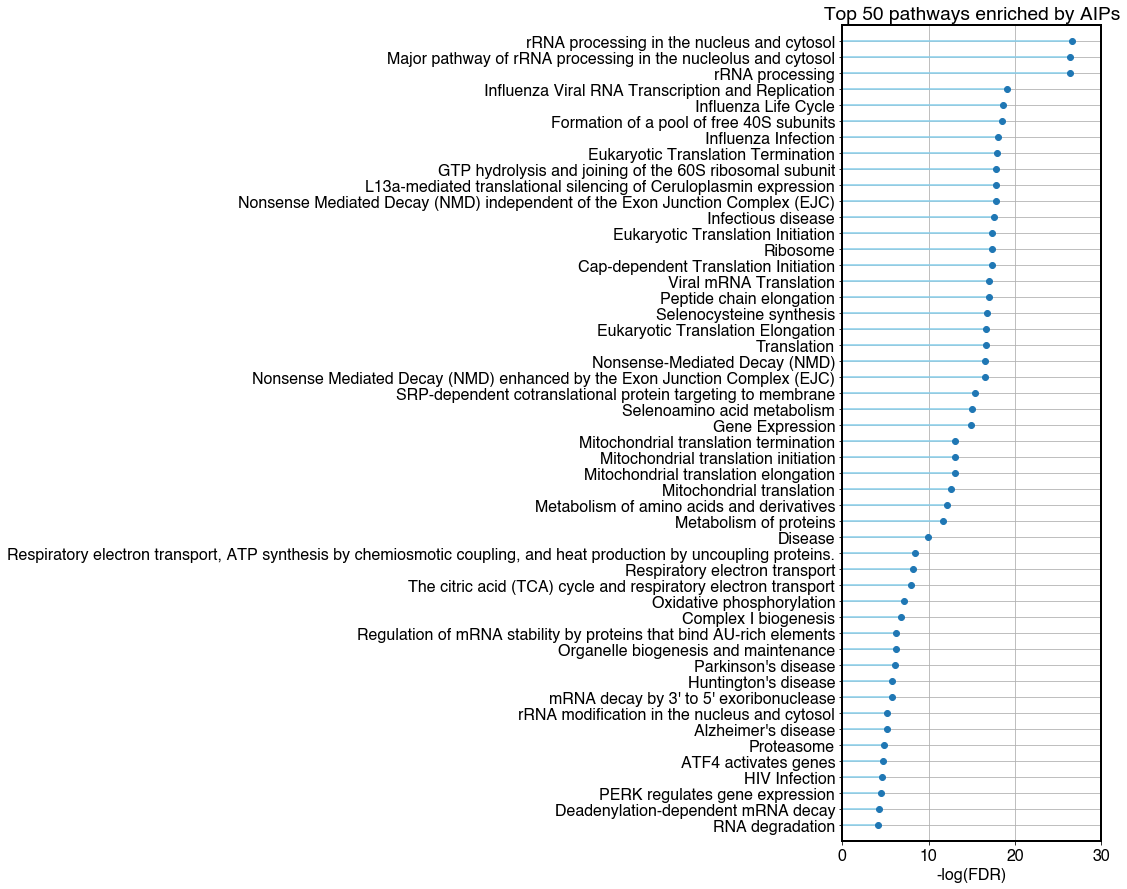

In [440]:
fig = plt.figure(figsize=(18,15))
topN = 50
plt.grid()
plt.hlines(y=range(topN),
           xmin=0,
           xmax=pathway_df['-log(FDR)'][:topN],
           color='skyblue')
plt.plot(pathway_df['-log(FDR)'][:topN], range(topN), "o")
plt.yticks(range(topN), pathway_df['Name'])
plt.xlabel("-log(FDR)")
plt.ylim(-1, topN)
plt.xlim(0, 30)
plt.gca().invert_yaxis()
plt.title("Top 50 pathways enriched by AIPs")
plt.gcf().subplots_adjust(left=0.7)

# plt.tight_layout()
plt.savefig("../../plots/Fig4F.pdf", dpi=500)
